In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from loading import load_session_data
from behavior import get_behav_units
from scipy import stats
from scipy import signal
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
from sklearn.cluster import DBSCAN

from population import unit_response_matrix, activity_at_phase

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
#sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]

selected = [
    '009265_hippoSIT_2023-03-09_20-03-08',
    '009265_hippoSIT_2023-03-05_11-52-17'
]
selected

['009265_hippoSIT_2023-03-09_20-03-08', '009265_hippoSIT_2023-03-05_11-52-17']

In [6]:
umap_dists   = [0.1, 0.3, 0.5, 0.7]
perplexities = [20, 50, 70, 100]

## BGR / TGT / SIL

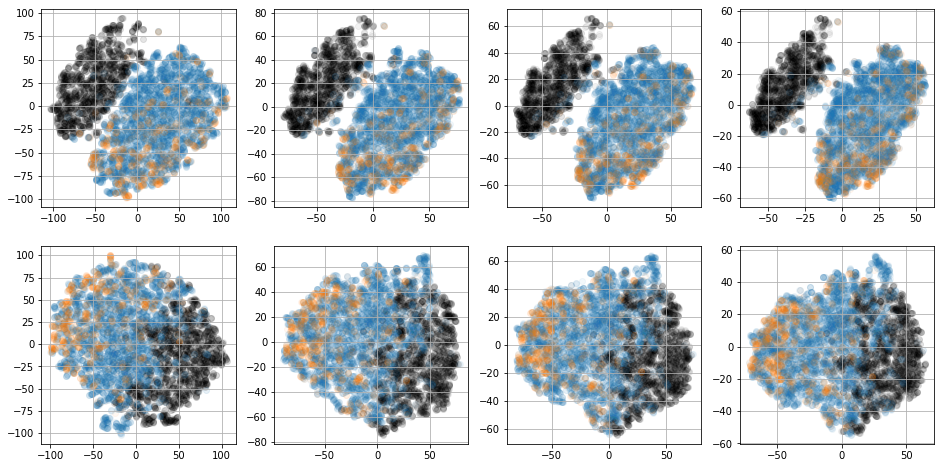

In [10]:
rows = len(selected)
cols = 4
size = 4
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

for i, session in enumerate(selected):
    # load data
    animal = session.split('_')[0]
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_WX.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
        
#     idxs_srm_bgr = np.where(tl[idxs_srm_tl][:, 6] == 1)[0]
#     idxs_srm_sil = np.where(tl[idxs_srm_tl][:, 6] == 0)[0]
#     idxs_srm_tgt = np.where(tl[idxs_srm_tl][:, 6] == 2)[0]
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]

    #for j, dist in enumerate(umap_dists):
    for j, dist in enumerate(perplexities):
        with h5py.File(moseq_class_file, 'r') as f:
            fit = np.array(f['tSNE'][str(dist)])

        ax = axes[i][j]
        ax.scatter(fit[idxs_sil_ev][:, 0], fit[idxs_sil_ev][:, 1], alpha=0.05, color='black')
        ax.scatter(fit[idxs_bgr_ev][:, 0], fit[idxs_bgr_ev][:, 1], alpha=0.05, color='tab:blue')
        ax.scatter(fit[idxs_tgt_ev][:, 0], fit[idxs_tgt_ev][:, 1], alpha=0.05, color='tab:orange')
        ax.grid()

## Succ / fail in targets

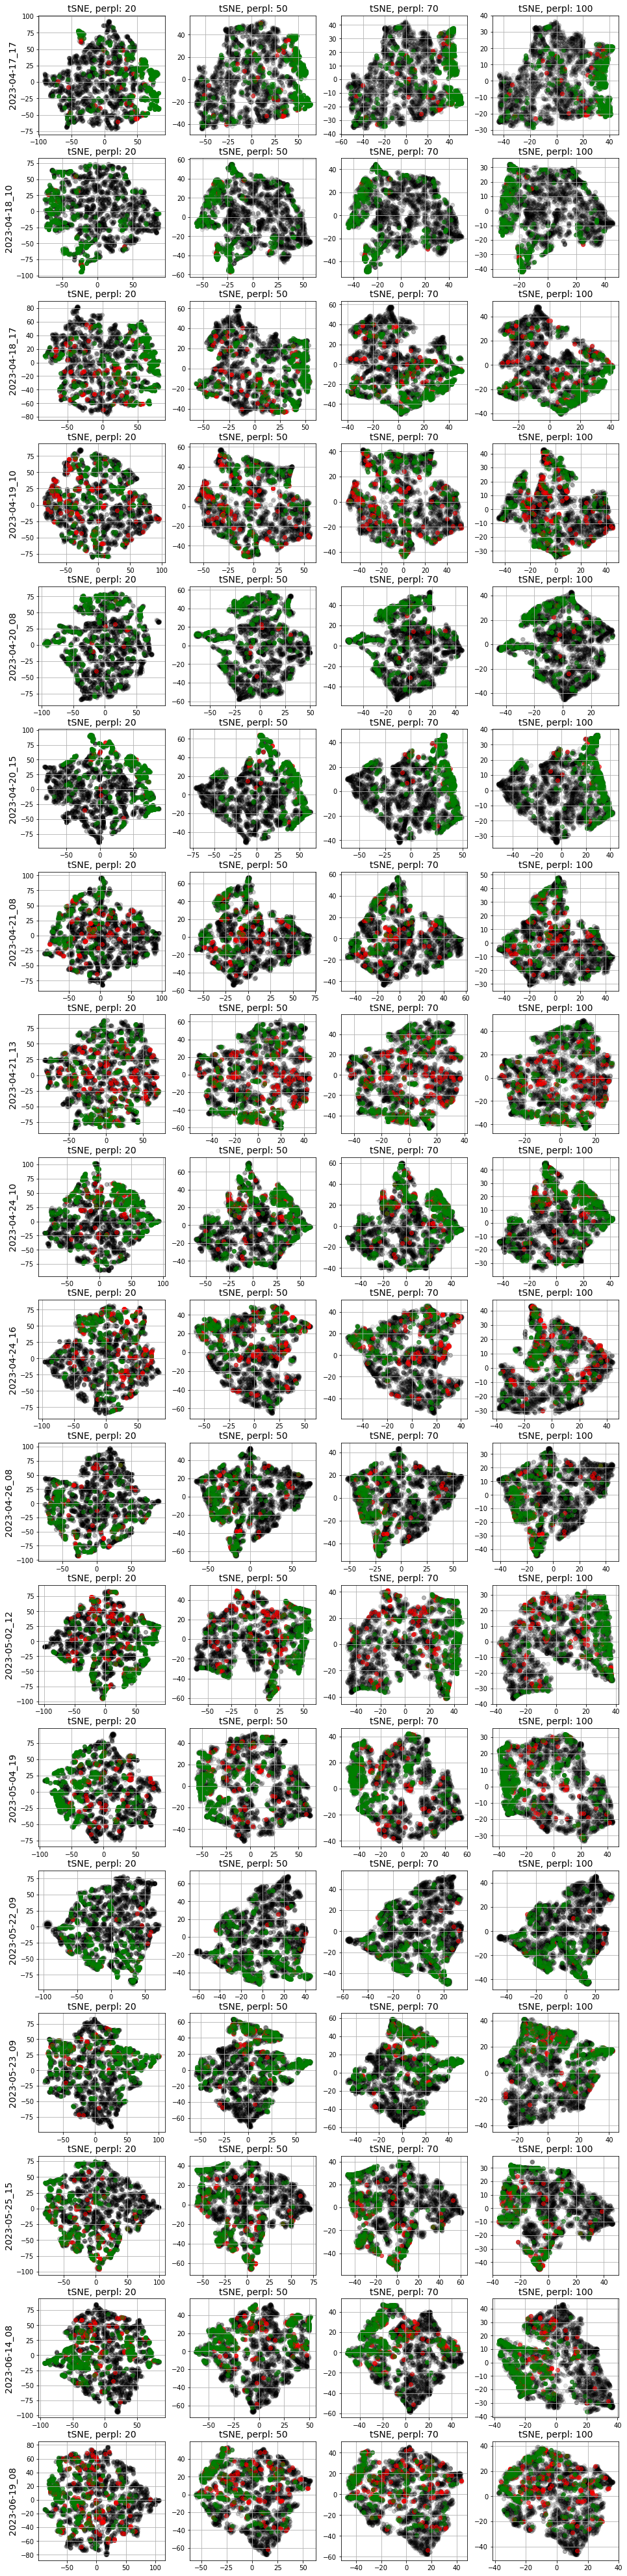

In [66]:
fit_type = 'tSNE'
rows = len(selected)
cols = 4
size = 4
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_class_500.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
        
    idxs_srm_succ = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        tl_l, tl_r = tgt_rec[2], tgt_rec[3]
        idxs_srm_succ += list(np.where((idxs_srm_tl > tl_l) & (idxs_srm_tl < tl_r))[0])
    
    idxs_srm_fail = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 0]:
        tl_l, tl_r = tgt_rec[2], tgt_rec[3]
        idxs_srm_fail += list(np.where((idxs_srm_tl > tl_l) & (idxs_srm_tl < tl_r))[0])
    
    params = perplexities if fit_type == 'tSNE' else umap_dists
    for j, dist in enumerate(params):
        with h5py.File(moseq_class_file, 'r') as f:
            fit = np.array(f[fit_type][str(dist)])

        title = "%s, %s: %s" % (fit_type, 'perpl' if fit_type == 'tSNE' else 'dist', str(dist))
        ax = axes[i][j]
        ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, color='black')
        ax.scatter(fit[idxs_srm_fail][:, 0], fit[idxs_srm_fail][:, 1], alpha=0.55, color='red')
        ax.scatter(fit[idxs_srm_succ][:, 0], fit[idxs_srm_succ][:, 1], alpha=0.55, color='green')
        ax.grid()
        ax.set_title(title, fontsize=14)
        if j == 0:
            ax.set_ylabel(session[-19:-6], fontsize=14)

## W1 - W4

In [79]:
selected = sessions[:]
try:
    selected.remove('009266_hippoSIT_2023-04-20_15-24-14')
except:
    pass
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

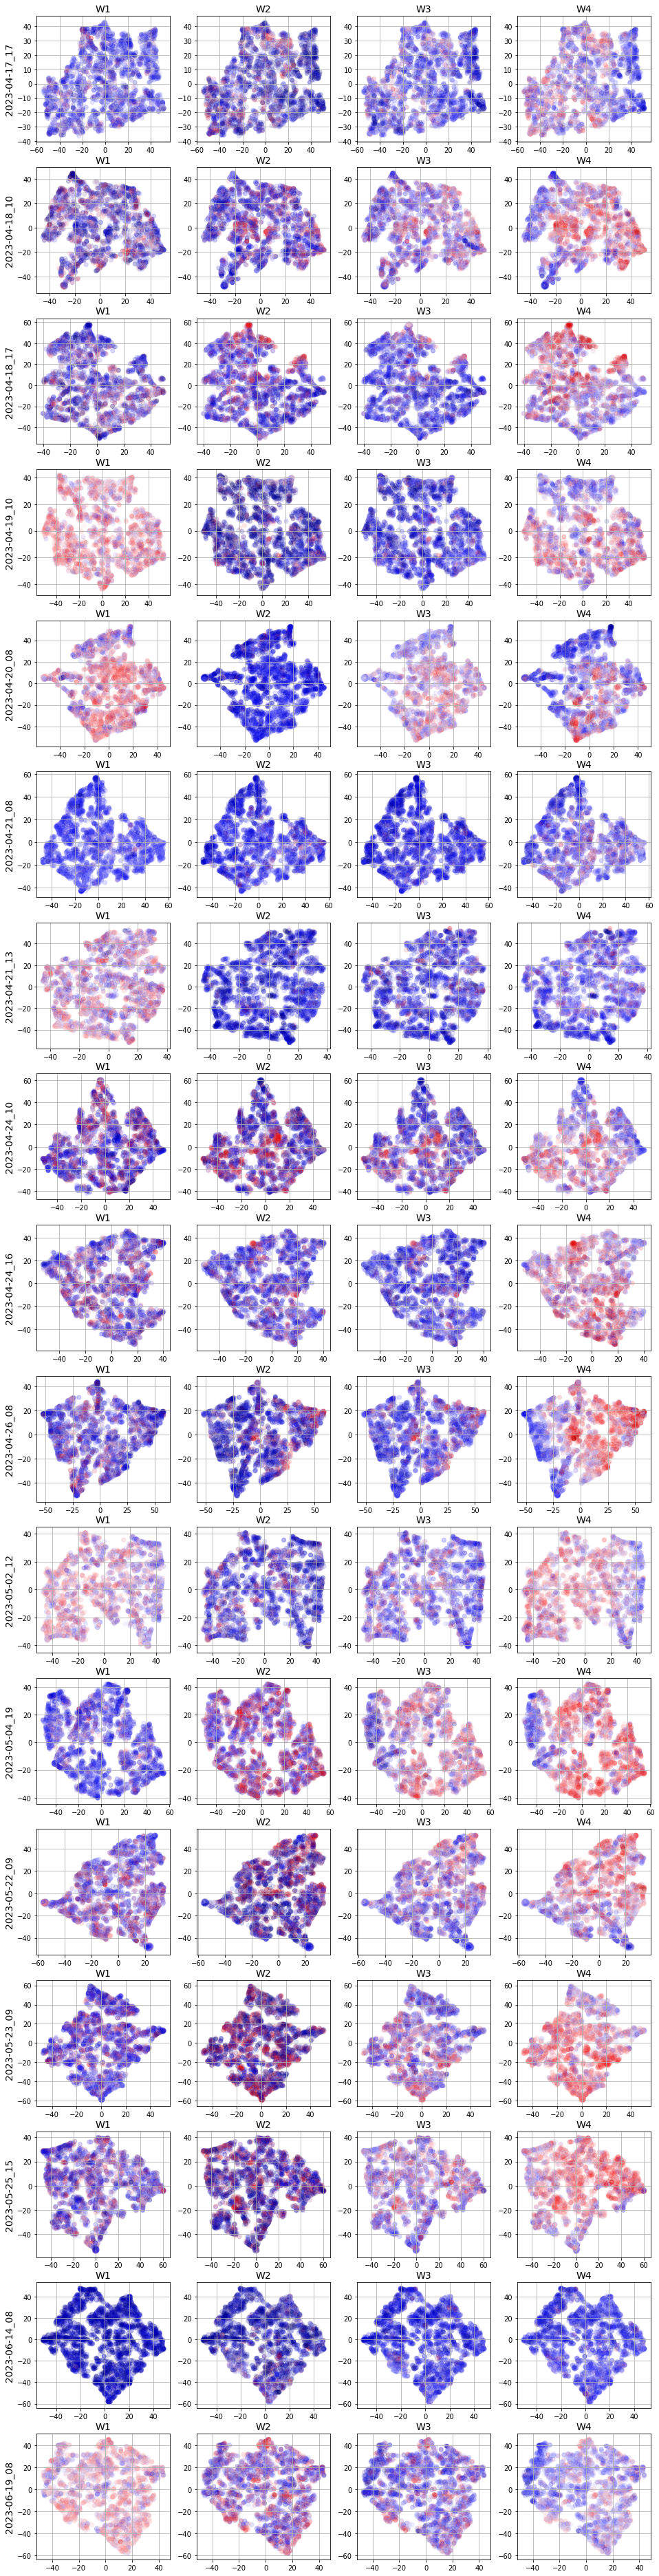

In [80]:
fit_type = 'tSNE'
fit_parm = 70
rows = len(selected)
cols = 4
size = 4
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path           = os.path.join(source, animal, session)
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_class_500.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
    with h5py.File(moseq_class_file, 'r') as f:
        fit = np.array(f[fit_type][str(fit_parm)])
        
    for j, phase in enumerate([1, 2, 3, 4]):
        w_pca = activity_at_phase(s_path, phase, do_pca=True)
        w_int = np.interp(tl[idxs_srm_tl][:, 0], events[:, 0], w_pca)
        #w_int = stats.zscore(w_int)

        ax = axes[i][j]
        ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, cmap='seismic', c=w_int)
        ax.grid()
        ax.set_title("W%s" % str(phase), fontsize=14)
        if j == 0:
            ax.set_ylabel(session[-19:-6], fontsize=14)

/tmp/ipykernel_1547202/796886077.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(w_int))


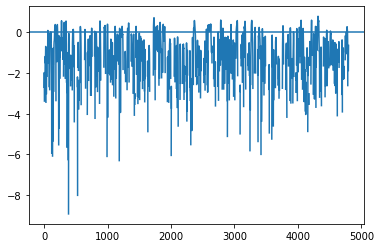

In [76]:


plt.plot(np.log(w_int))
plt.axhline(w_int.mean())


In [15]:
session = selected[0]

animal    = session.split('_')[0]
s_path    = os.path.join(source, animal, session)
meta_file = os.path.join(source, animal, session, 'meta.h5')
moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_class_500.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    events = np.array(f['processed']['sound_events'])
with h5py.File(moseq_class_file, 'r') as f:
    idxs_srm_tl = np.array(f['idxs_srm_tl'])

w4_pca   = activity_at_phase(s_path, 4, do_pca=True)
w4_nopca = activity_at_phase(s_path, 4, do_pca=False)
w4_int = np.interp(tl[idxs_srm_tl][:, 0], events[:, 0], w4_pca)

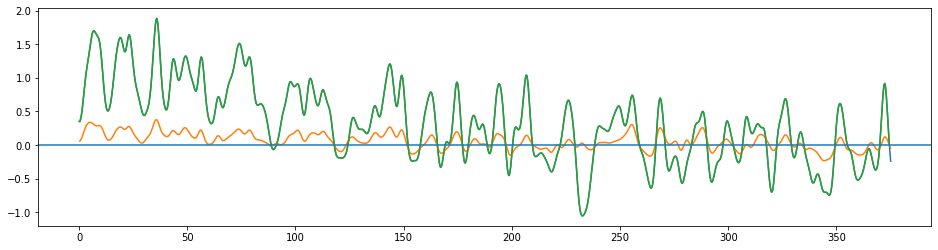

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

x_l, x_r = 0, 1500
ax.plot(events[:, 0][x_l:x_r], w4_pca[x_l:x_r])
ax.plot(events[:, 0][x_l:x_r], w4_nopca[x_l:x_r])
ax.plot(tl[idxs_srm_tl][:, 0][x_l:int(x_r/2)], w4_int[x_l:int(x_r/2)])

ax.axhline(0)